### **Task : Apply transfer learning techniques by training a model on a European dataset and then fine-tuning it for predicting GSNR (General Signal-to-Noise Ratio) on a USA dataset. ***

**Step 1 : Understanding Transfer Learning**

Transfer learning involves utilizing a pre-trained model on a new task or dataset. The idea is to transfer the knowledge gained from one task (source domain) to improve the performance on a different but related task (target domain). This approach is particularly useful when the target domain has limited labeled data but the source domain has a large amount of labeled data.

**Step 2 : Data Preparation**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [20]:
# Load European dataset
european_data = pd.read_excel('/content/DataSet_EU_3k_5k.xlsx')

In [21]:
# Load USA dataset
# Load the Excel file, specifying the sheet name
usa_data = pd.read_excel('/content/DataSet_USA_3k_5k.xlsx', sheet_name='Sheet1')

In [22]:
# Drop columns frequency_1 to frequency_76 and GSNR_2 to GSNR_76
columns_to_drop = [f'frequency_{i}' for i in range(1, 77)] + [f'GSNR_{i}' for i in range(2, 77)]

european_data = european_data.drop(columns=columns_to_drop)

In [23]:
# Columns to drop
columns_to_drop_usa = (
    [f'frequency_{i}' for i in range(1, 77)] +
    [f'GSNR_{i}' for i in range(2, 77)] +
    ['Source', 'Destination', 'Number of ON channels'] +
    [f'SNR_NL_{i}' for i in range(1, 77)] +
    [f'OSNR_{i}' for i in range(1, 77)]
)
usa_data = usa_data.drop(columns=columns_to_drop_usa)

In [24]:
# Basic exploration
print(european_data.head())
print(european_data.info())
print(european_data.describe())

print(usa_data.head())
print(usa_data.info())
print(usa_data.describe())

    Power_1   Power_2   Power_3   Power_4   Power_5   Power_6   Power_7  \
0  0.000000  0.000000  0.000007  0.000007  0.000007  0.000000  0.000007   
1  0.000000  0.000007  0.000000  0.000007  0.000000  0.000007  0.000000   
2  0.000000  0.000000  0.000000  0.000007  0.000000  0.000000  0.000000   
3  0.000007  0.000007  0.000007  0.000007  0.000007  0.000000  0.000000   
4  0.000000  0.000000  0.000007  0.000000  0.000007  0.000000  0.000000   

   Power_8   Power_9  Power_10  ...        ASE_70        ASE_71        ASE_72  \
0      0.0  0.000007       0.0  ...  7.544798e-06  7.544798e-06  7.544798e-06   
1      0.0  0.000000       0.0  ...  4.300201e-08  7.353422e-06  7.353422e-06   
2      0.0  0.000007       0.0  ...  7.411925e-06  4.770912e-08  7.411925e-06   
3      0.0  0.000007       0.0  ...  4.777708e-08  4.761294e-08  4.990965e-08   
4      0.0  0.000007       0.0  ...  7.187909e-06  4.648247e-08  4.506342e-08   

         ASE_73        ASE_74        ASE_75        ASE_76     

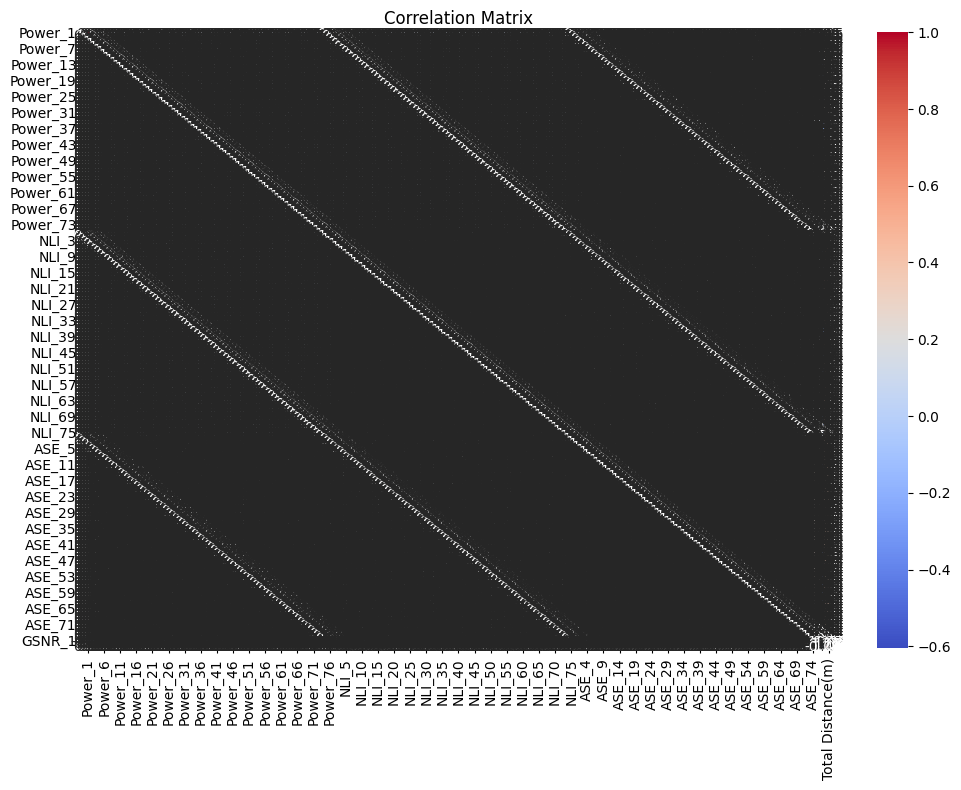

In [41]:
# Select relevant columns
features = european_data.columns.difference(['GSNR_1'])
target = 'GSNR_1'

# Combine the datasets for visualization
european_data['Dataset'] = 'European'
usa_data['Dataset'] = 'USA'
combined_data = pd.concat([european_data, usa_data])

# Correlation matrix (excluding 'Dataset' column)
plt.figure(figsize=(12, 8))
correlation_matrix = combined_data.drop(columns=['Dataset']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [42]:
# Number of columns for the subplots
num_cols = 5

# Individual feature distributions
num_features = len(features)
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(combined_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# Relationship with target variable
plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.scatterplot(x=combined_data[feature], y=combined_data[target], hue=combined_data['Dataset'])
    plt.title(f'Relationship between {feature} and {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

In [25]:
#Select relevant columns for features and target
features = european_data.columns.difference(['GSNR_1', 'Dataset'])
target = 'GSNR_1'

# Separate features and target
X_european = european_data[features]
y_european = european_data[[target]]  # Ensure y is a DataFrame for consistent scaling
X_usa = usa_data[features]
y_usa = usa_data[[target]]  # Ensure y is a DataFrame for consistent scaling

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assume european_data and usa_data are your DataFrames

# Select relevant columns for features and target
features = european_data.columns.difference(['GSNR_1', 'Dataset'])
target = 'GSNR_1'

# Separate features and target
X_european = european_data[features]
y_european = european_data[[target]]  # Ensure y is a DataFrame for consistent scaling
X_usa = usa_data[features]
y_usa = usa_data[[target]]  # Ensure y is a DataFrame for consistent scaling

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features and target
X_european_scaled = scaler.fit_transform(X_european)
y_european_scaled = scaler.fit_transform(y_european)

X_usa_scaled = scaler.fit_transform(X_usa)
y_usa_scaled = scaler.fit_transform(y_usa)

# Flatten the target variables
y_european_flat = y_european_scaled.flatten()
y_usa_flat = y_usa_scaled.flatten()

# Convert the scaled features back to DataFrames for easier handling
X_european_scaled = pd.DataFrame(X_european_scaled, columns=features)
X_usa_scaled = pd.DataFrame(X_usa_scaled, columns=features)

# Convert the flattened target variables back to Series for consistency
y_european_flat = pd.Series(y_european_flat, name=target)
y_usa_flat = pd.Series(y_usa_flat, name=target)

**Step 3 : Model Training on European Dataset**

In [27]:
from tensorflow.keras.layers import Dropout
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_european_scaled, y_european_flat, test_size=0.3, random_state=42)
# Define the model with the best hyperparameters
initial_model = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.0),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
initial_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
initial_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Save the initial model
initial_model.save('initial_gsnr_model.h5')

# Evaluate the model
y_pred_val = initial_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f"Initial Model - MSE: {mse_val}, R²: {r2_val}")

Epoch 1/100
394/394 [==============================] - 3s 5ms/step - loss: 0.7894 - val_loss: 0.6172
Epoch 2/100
394/394 [==============================] - 2s 4ms/step - loss: 0.5270 - val_loss: 0.3699
Epoch 3/100
394/394 [==============================] - 1s 3ms/step - loss: 0.2926 - val_loss: 0.1634
Epoch 4/100
394/394 [==============================] - 1s 3ms/step - loss: 0.1121 - val_loss: 0.0622
Epoch 5/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0584 - val_loss: 0.0438
Epoch 6/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0425 - val_loss: 0.0320
Epoch 7/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0330 - val_loss: 0.0375
Epoch 8/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0259 - val_loss: 0.0186
Epoch 9/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0168
Epoch 10/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0160 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 0s 1ms/step
Initial Model - MSE: 0.0017333004215133545, R²: 0.9982491225128933


**Step 4 : Transfer Learning - Feature Extraction**

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the pre-trained model
base_modelm = load_model('initial_gsnr_model.h5')

# Freeze the initial layers
for layer in base_modelm.layers[:-1]:
    layer.trainable = False

# Create a new Sequential model and add all layers except the last one from the pre-trained model
new_model = Sequential()
for layer in base_modelm.layers[:-1]:
    new_model.add(layer)

# Add new layers suitable for the USA dataset
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='linear'))

# Compile the new model
new_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Split the USA data into training and validation sets
X_train_usa, X_val_usa, y_train_usa, y_val_usa = train_test_split(X_usa_scaled, y_usa_flat, test_size=0.3, random_state=42)

# Train the new layers on the USA dataset
history_fe = new_model.fit(X_train_usa, y_train_usa, epochs=100, batch_size=32, validation_data=(X_val_usa, y_val_usa))

# Evaluate the new model on the USA validation set
y_pred_val_usa = new_model.predict(X_val_usa)
mse_val_usa = mean_squared_error(y_val_usa, y_pred_val_usa)
r2_val_usa = r2_score(y_val_usa, y_pred_val_usa)
print(f"New Model - MSE: {mse_val_usa}, R²: {r2_val_usa}")

# Save the feature extraction model
new_model.save('feature_extraction_gsnr_model.keras')

Epoch 1/100
788/788 [==============================] - 3s 3ms/step - loss: 0.7734 - val_loss: 0.5883
Epoch 2/100
788/788 [==============================] - 2s 3ms/step - loss: 0.5870 - val_loss: 0.5516
Epoch 3/100
788/788 [==============================] - 5s 6ms/step - loss: 0.5580 - val_loss: 0.5213
Epoch 4/100
788/788 [==============================] - 2s 3ms/step - loss: 0.5292 - val_loss: 0.5096
Epoch 5/100
788/788 [==============================] - 2s 3ms/step - loss: 0.4971 - val_loss: 0.4641
Epoch 6/100
788/788 [==============================] - 2s 3ms/step - loss: 0.4662 - val_loss: 0.4277
Epoch 7/100
788/788 [==============================] - 2s 3ms/step - loss: 0.4288 - val_loss: 0.3920
Epoch 8/100
788/788 [==============================] - 2s 3ms/step - loss: 0.3925 - val_loss: 0.3573
Epoch 9/100
788/788 [==============================] - 3s 4ms/step - loss: 0.3610 - val_loss: 0.3539
Epoch 10/100
788/788 [==============================] - 2s 2ms/step - loss: 0.3240 - val_lo

**Step 5: Transfer Learning - Fine-Tuning**

In [38]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the pre-trained model
base_modelt = load_model('initial_gsnr_model.h5')

# Create a new model based on the pre-trained model
base_model = tf.keras.models.clone_model(base_modelt)
base_model.set_weights(base_modelt.get_weights())

# Split the USA data into training and validation sets
X_train_usa_ft, X_val_usa_ft, y_train_usa_ft, y_val_usa_ft = train_test_split(X_usa_scaled, y_usa_flat, test_size=0.3, random_state=42)

# Unfreeze more layers (e.g., unfreeze 50% of the layers)
num_layers = len(base_model.layers)
num_layers_to_freeze = num_layers // 2  # Freeze only 50% of the layers

for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Compile the model with a lower learning rate
base_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model on the USA dataset with a different batch size
history_ft = base_model.fit(X_train_usa_ft, y_train_usa_ft, epochs=100, batch_size=32, validation_data=(X_val_usa_ft, y_val_usa_ft))

# Evaluate the model on the USA validation set
y_pred_val_usa_ft = base_model.predict(X_val_usa_ft)
mse_val_usa_ft = mean_squared_error(y_val_usa_ft, y_pred_val_usa_ft)
r2_val_usa_ft = r2_score(y_val_usa_ft, y_pred_val_usa_ft)
print(f"Fine-Tuned Model - MSE: {mse_val_usa_ft}, R²: {r2_val_usa_ft}")

# Save the fine-tuned model
base_model.save('fine_tuned_gsnr_model_full.keras')


Epoch 1/100
788/788 [==============================] - 4s 4ms/step - loss: 0.7159 - val_loss: 0.5548
Epoch 2/100
788/788 [==============================] - 2s 3ms/step - loss: 0.5497 - val_loss: 0.5347
Epoch 3/100
788/788 [==============================] - 2s 3ms/step - loss: 0.5303 - val_loss: 0.5118
Epoch 4/100
788/788 [==============================] - 2s 2ms/step - loss: 0.5231 - val_loss: 0.5043
Epoch 5/100
788/788 [==============================] - 2s 2ms/step - loss: 0.5168 - val_loss: 0.5127
Epoch 6/100
788/788 [==============================] - 2s 3ms/step - loss: 0.5133 - val_loss: 0.4881
Epoch 7/100
788/788 [==============================] - 3s 4ms/step - loss: 0.5035 - val_loss: 0.4789
Epoch 8/100
788/788 [==============================] - 2s 3ms/step - loss: 0.4966 - val_loss: 0.4706
Epoch 9/100
788/788 [==============================] - 2s 2ms/step - loss: 0.4863 - val_loss: 0.4633
Epoch 10/100
788/788 [==============================] - 2s 3ms/step - loss: 0.4744 - val_lo

**Step 6 : Comparison and Analysis**

In [39]:
# Results from feature extraction method
mse_fe = mse_val_usa
r2_fe = r2_val_usa

# Results from fine-tuning method
mse_ft = mse_val_usa_ft
r2_ft = r2_val_usa_ft

print(f"Feature Extraction - MSE: {mse_fe}, R²: {r2_fe}")
print(f"Fine-Tuning - MSE: {mse_ft}, R²: {r2_ft}")

Feature Extraction - MSE: 0.012833457962660607, R²: 0.9867538508860219
Fine-Tuning - MSE: 0.006404186067556994, R²: 0.9933898717047783


**Visualisation**

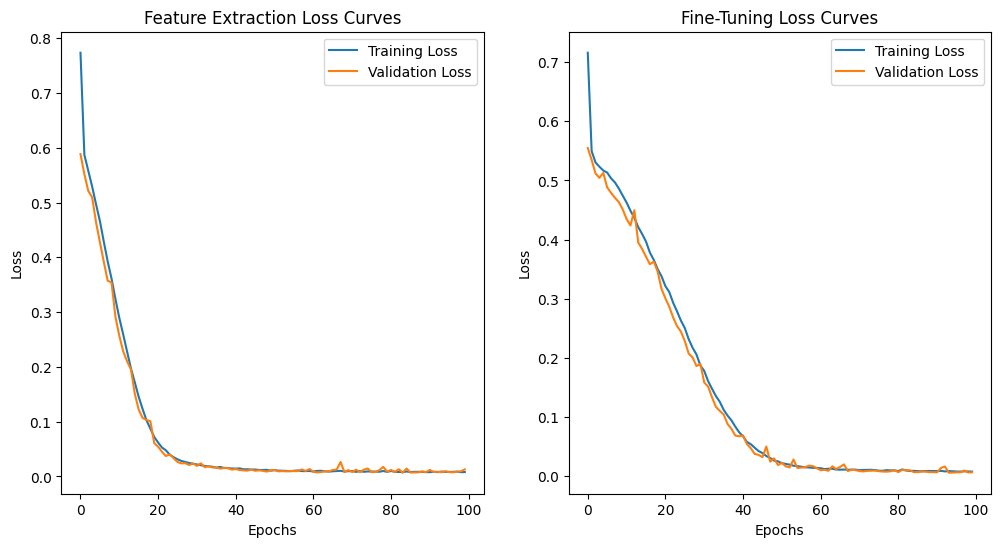

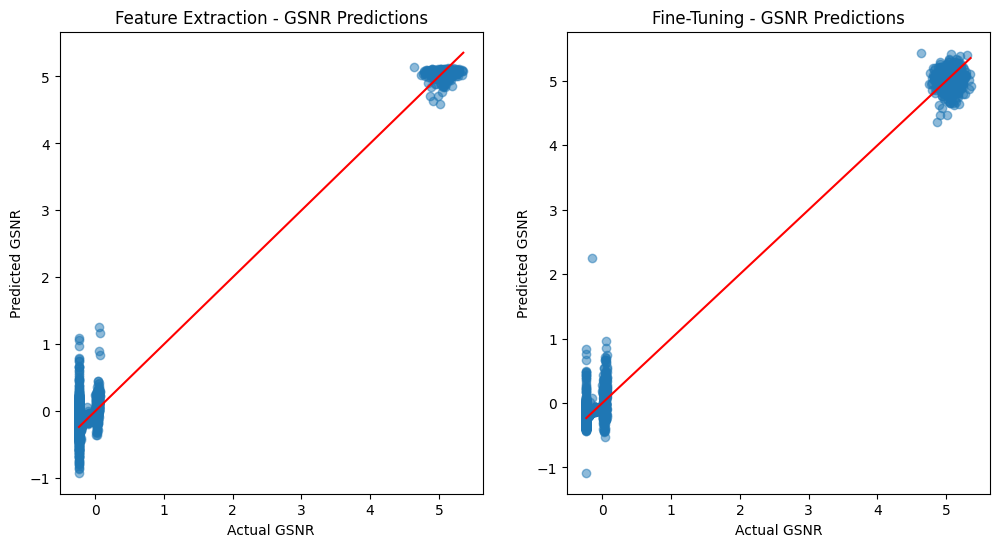

In [40]:
# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))

# Feature Extraction Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history_fe.history['loss'], label='Training Loss')
plt.plot(history_fe.history['val_loss'], label='Validation Loss')
plt.title('Feature Extraction Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fine-Tuning Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Training Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# GSNR Prediction Accuracy Scatter Plot
plt.figure(figsize=(12, 6))

# Feature Extraction Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_val_usa, y_pred_val_usa, alpha=0.5)
plt.plot([min(y_val_usa), max(y_val_usa)], [min(y_val_usa), max(y_val_usa)], color='red')
plt.title('Feature Extraction - GSNR Predictions')
plt.xlabel('Actual GSNR')
plt.ylabel('Predicted GSNR')

# Fine-Tuning Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_val_usa, y_pred_val_usa_ft, alpha=0.5)
plt.plot([min(y_val_usa), max(y_val_usa)], [min(y_val_usa), max(y_val_usa)], color='red')
plt.title('Fine-Tuning - GSNR Predictions')
plt.xlabel('Actual GSNR')
plt.ylabel('Predicted GSNR')

plt.show()